In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

## Importing CSVs

In [2]:
dfMovies = pd.read_csv(
    "content/IMDb movies w top_actor, top_actor_gender.csv",
    dtype={"year": str, "budget": str},
    sep="\t",
)
dfNames = pd.read_csv("content/IMDb names.csv")
dfRatings = pd.read_csv("content/IMDb ratings.csv")
dfTitlePrincipals = pd.read_csv("content/IMDb title_principals.csv")

In [3]:
dfMovies.shape

(85220, 24)

In [4]:
# Pick the columns from each of the datasets that should be used to train the ML algorithms
dfMovies = dfMovies[
    [
        "imdb_title_id",
        "title",
        "year",
        "genre",
        "duration",
        "country",
        "language",
        "director",
        "writer",
        "production_company",
        "budget",
        "top_actor",
        "top_actor_gender",
        "date_published"
    ]
]

dfRatings = dfRatings[
    ["imdb_title_id", "weighted_average_vote"]
]  # come back to this and include age groups/male/female votes
dfTitlePrincipals = dfTitlePrincipals[
    ["imdb_title_id", "ordering", "imdb_name_id"]
]  # should we get category? "actress"/"actor" (dont know if its necessary)

dfMovies = pd.merge(dfMovies, dfRatings, on=["imdb_title_id"])

dfMovies.shape

(85220, 15)

## Merging dfNames with dfMovies

In [5]:
dfNames = dfNames.drop_duplicates("name")

dfMovies_Names = pd.merge(
    dfMovies,
    dfNames[
        [
            "name",
            "height",
            "divorces",
            "date_of_birth",
            "date_of_death",
        ]
    ],
    left_on=["top_actor"],
    right_on=["name"]
).drop(columns=["name"])

In [6]:
dfMovies_Names.shape

(85220, 19)

In [7]:
dfMovies_Names.dtypes

imdb_title_id             object
title                     object
year                      object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
budget                    object
top_actor                 object
top_actor_gender          object
date_published            object
weighted_average_vote    float64
height                   float64
divorces                   int64
date_of_birth             object
date_of_death             object
dtype: object

## Adding `actor_age_at_release` to dfMovies_Names

In [8]:
def calc_age_at_release(row):
    try:
        born = datetime.strptime(row["date_of_birth"], "%Y-%m-%d").date()
        released = datetime.strptime(row["date_published"], "%Y-%m-%d").date()
        
        age = int(released.year - born.year)
        
        return age if age > 0 and age < 120 else None
    except:
        return None

Function to calculate the top actors age and the top actor age when the movie is released.

In [9]:
dfMovies_Names["actor_age_at_release"] = dfMovies_Names.apply(calc_age_at_release, axis=1)

In [10]:
dfMovies_Names["actor_age_at_release"].describe()

count    64295.000000
mean        39.167198
std         13.095969
min          1.000000
25%         30.000000
50%         37.000000
75%         47.000000
max        119.000000
Name: actor_age_at_release, dtype: float64

In [11]:
dfMovies_Names = dfMovies_Names.drop(columns=["date_of_birth", "date_of_death", "date_published"])

Dropping the features used to calculate the new features.

In [12]:
dfMovies_Names.dropna().shape

(15688, 17)

## Binning `actor_age_at_release`

In [13]:
dfMovies_Names["actor_age_at_release"], bins = pd.cut(
    dfMovies_Names["actor_age_at_release"],
    4,
    labels=["child", "teenager", "adult", "old"],
    retbins=True,
)

In [14]:
bins

array([  0.882,  30.5  ,  60.   ,  89.5  , 119.   ])

## Casting `year` and `budget` features

In [15]:
dfMovies_Names["year"] = dfMovies_Names["year"].astype(str).str.extract("(\d+)")
dfMovies_Names["budget"] = dfMovies_Names["budget"].astype(str).str.extract("(\d+)")

dfMovies_Names.year = pd.to_numeric(dfMovies_Names.year, errors="coerce").astype("Int64")
dfMovies_Names.budget = pd.to_numeric(dfMovies_Names.budget, errors="coerce").astype("Int64")

In [16]:
dfMovies_Names.dtypes

imdb_title_id              object
title                      object
year                        Int64
genre                      object
duration                    int64
country                    object
language                   object
director                   object
writer                     object
production_company         object
budget                      Int64
top_actor                  object
top_actor_gender           object
weighted_average_vote     float64
height                    float64
divorces                    int64
actor_age_at_release     category
dtype: object

## Removing nulls and renaming

In [17]:
dfMovies_Names = dfMovies_Names.dropna()
df = dfMovies_Names

In [18]:
df.shape

(15688, 17)

Dropping any rows with `NaN`.

## Scaling Continuous Features

In [19]:
to_scale = [
    "duration",
    "budget",
    "height",
    "divorces"
]

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for col in to_scale:
    print(f"scaling {col}...")
    df[[col]] = scaler.fit_transform(df[[col]])

scaling duration...
scaling budget...
scaling height...
scaling divorces...


## Analyzing Categorical Features

### `genre`

In [21]:
df["genre"].value_counts()

Drama                           1147
Comedy                           812
Comedy, Drama                    590
Drama, Romance                   547
Comedy, Drama, Romance           545
                                ... 
Drama, War, Thriller               1
Action, Crime, Comedy              1
Fantasy, Horror, Musical           1
Adventure, Romance, Thriller       1
Action, Fantasy, Western           1
Name: genre, Length: 666, dtype: int64

It looks like there are a significant number of movies that classify as the same genre.

In [22]:
genre_1_freq = (
    df["genre"].value_counts().where(df["genre"].value_counts() == 1).dropna()
)

print(genre_1_freq.shape)

genre_over_100_freq = (
    df["genre"].value_counts().where(df["genre"].value_counts() > 100).dropna()
)

print(genre_over_100_freq.shape)
print(genre_over_100_freq.sum())
print(f"{(genre_over_100_freq.sum()) / (df.shape[0])*100:.0f}%")

(223,)
(30,)
8584.0
55%


Specifically, there are 227 genres that only classify *one movie*. However there are 33 genres that classify over 100 movies. In total, those 33 genres account for 9,619 movies, which is over 50% of the movies in our dataset.

Therefore, it's probably safe to just OneHotEncode the existing values in `genres`.

Similar analysis of the following features are below.

### Other categorical features

In [23]:
to_encode = [
    "genre",
    "country",
    "language",
    "director",
    "writer",
    "production_company",
    "top_actor"
]


GENRE --------------------------------------------

num of categories with 1 movie: 223

num of categories with over 100 movies: 30 which accounts for 8584

num of categories with > 100 movie: 30
accounts for 8584 or 55% of the dataset

COUNTRY --------------------------------------------

num of categories with 1 movie: 1212

num of categories with over 100 movies: 17 which accounts for 11476

num of categories with > 100 movie: 17
accounts for 11476 or 73% of the dataset

LANGUAGE --------------------------------------------

num of categories with 1 movie: 1155

num of categories with over 100 movies: 13 which accounts for 11658

num of categories with > 100 movie: 13
accounts for 11658 or 74% of the dataset

DIRECTOR --------------------------------------------

num of categories with 1 movie: 5386

num of categories with over 100 movies: 0 which accounts for 0

num of categories with > 100 movie: 0
accounts for 0 or 0% of the dataset

WRITER --------------------------------------

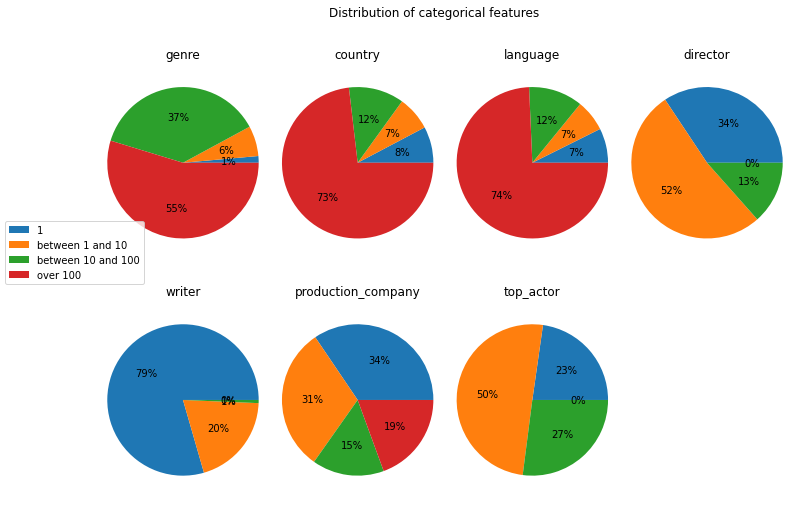

In [24]:
rows = df.shape[0]
labels = ["1", "between 1 and 10", "between 10 and 100", "over 100"]

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 8)
plt.suptitle("Distribution of categorical features")

axs = axs.flatten()

for i, col in enumerate(to_encode):
    data = []
    
    print(f"\n{col.upper()} --------------------------------------------")
    vc = df[col].value_counts()

    filtered = vc.where(vc == 1).dropna()
    data.append((filtered.sum() / rows) * 100)

    print(f"\nnum of categories with 1 movie: {filtered.shape[0]}")

    filtered = vc.where((vc > 1) & (vc <= 10)).dropna()
    data.append((filtered.sum() / rows) * 100)

    filtered = vc.where((vc > 10) & (vc <= 100)).dropna()
    data.append((filtered.sum() / rows) * 100)

    filtered = vc.where(vc > 100).dropna()
    
    data.append((filtered.sum() / rows) * 100)

    print(
        f"\nnum of categories with over 100 movies: {filtered.shape[0]} which accounts for {filtered.sum():.0f}"
    )

    axs[i].axis("equal")

    patches = axs[i].pie(data, autopct="%.0f%%", radius=1.3)[0]
    axs[i].set(ylabel='', title=col, aspect='equal')

    print(f"\nnum of categories with > 100 movie: {filtered.shape[0]}")
    print(
        f"accounts for {filtered.sum():.0f} or {(filtered.sum()/rows)*100:.0f}% of the dataset"
    )

axs[7].remove()
fig.legend(patches, labels, loc="center left")

## Encoding Functions

In [25]:
def encode_normal(df, col):
    return pd.get_dummies(df[col])

In [26]:
def other_col(row):
    if row.sum() == 0:
        return 1
    return 0

In [27]:
def encode_top_n(df, col, top):
    genre_encoded_df = pd.DataFrame()

    top_cat = pd.Index([f"{col}_{x}" for x in df[col].value_counts().index])[:top]
    genre_encoded_df = pd.get_dummies(df[col], prefix=col)[top_cat]

    genre_encoded_df["other_" + col] = genre_encoded_df.apply(other_col, axis=1)

    return genre_encoded_df

In [28]:
def encode_top_n_list(df, col, top):
    encoded = df[col].str.replace(" ", "").str.get_dummies(sep=",")

    encoded_sum = encoded.sum()
    ind = np.argsort(encoded.sum())
    top_cat = encoded.sum()[ind][-top:].index

    encoded["other_" + col] = encoded.apply(other_col, axis=1)
    
    return encoded[["other_" + col, *top_cat]]

`encode_normal` returns the encoded column in a DataFrame.

`encode_top_n` return the top `n` most frequent values encoded in a DataFrame with an `other_` column for all the other values.

`encode_top_n_list` splits each value on the comma character and returns the top `n` most frequent values encoded in a DataFrame with an `other_` column for all the other values.

## Encoding Categorical Columns

In [56]:
df = dfMovies_Names

In [57]:
to_encode = [
    "genre",
    "country",
    "language",
    "director",
    "writer",
    "production_company",
    "top_actor"
]

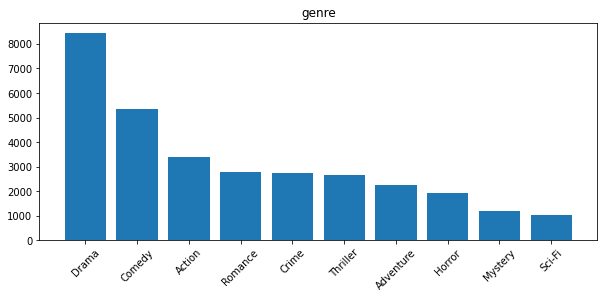

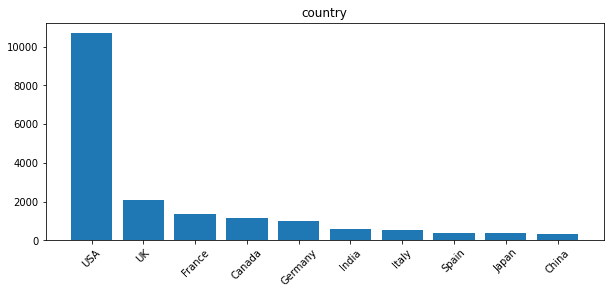

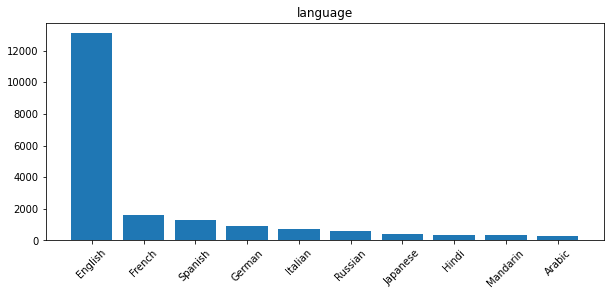

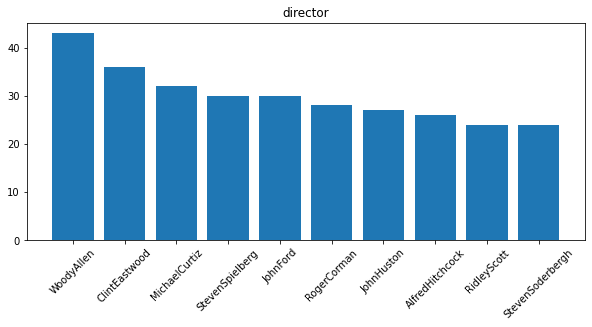

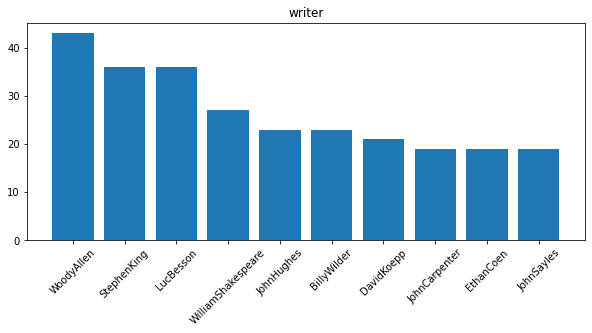

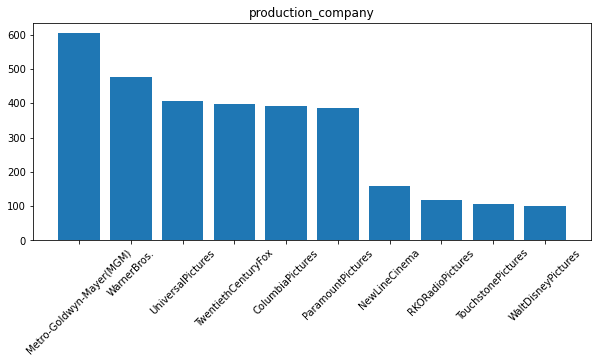

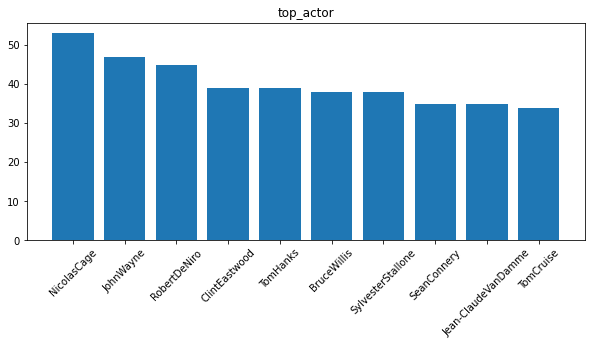

In [59]:
for col in to_encode:
    vc = df[col].str.replace(" ", "").str.get_dummies(sep=",").sum().sort_values(ascending=False)
    xs = vc[:10].index
    heights = vc[:10]

    plt.figure(figsize=(10, 4))
    plt.bar(xs, heights)
    plt.xticks(rotation=45)
    plt.title(col)
    plt.show()

In [50]:
rows = df.shape[0]
top = 100

for col in to_encode:
    print(f"encoding {col}...")

    #     vc = df[col].value_counts()
    #     filtered = vc.where(vc > 100).dropna().sum()
    
    vc = df[col].str.contains(",", regex=False).value_counts()
    
    rows_w_commas = vc[True] if True in vc else 0

    if (rows_w_commas / rows) > 0.5:
        print(f"{rows_w_commas / rows:.2f} of the values have commas")
        df = df.join(encode_top_n_list(df, col, top))
        df = df.drop(columns=[col])
    else:
        print(f"{rows_w_commas / rows:.2f} of the values have commas")
        df = df.join(encode_top_n(df, col, top))
        df = df.drop(columns=[col])

    print(df.dropna().shape)

encoding genre...
0.83 of the values have commas
(15688, 40)
encoding country...
0.27 of the values have commas
(15688, 140)
encoding language...
0.28 of the values have commas
(15688, 240)
encoding director...
0.07 of the values have commas
(15688, 340)
encoding writer...
0.70 of the values have commas
(15688, 440)
encoding production_company...
0.00 of the values have commas
(15688, 540)
encoding top_actor...
0.00 of the values have commas
(15688, 640)


# To Do:
- Z-score scale the continuous values

## Encoding `year`

In [52]:
to_encode_normal = [
    "year",
    "actor_age_at_release",
    "top_actor_gender"
]

In [53]:
for col in to_encode_normal:
    df = df.join(encode_normal(df, col))
    df = df.drop(columns=[col])
    print(df.dropna().shape)

(15688, 747)
(15688, 750)
(15688, 751)


## Output to CSV

In [54]:
df.shape

(15688, 751)

In [55]:
df.drop(columns=["imdb_title_id", "title"]).to_csv("content/combined_data_all_list_encoded_100.csv", index=False)